# Importation des packages

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import re
import string
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier  # Ajout pour multi-label

In [76]:
pip install wordcloud

# Importation des données

Ajoutez un raccourci de ce dossier à votre google drive :

https://drive.google.com/drive/folders/1mx-CAzT10YKrmxHfYDP_1Oef7PVGUr7s?usp=sharing

In [40]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [41]:
data = pd.read_csv('/content/drive/MyDrive/data_classification_commentaires_toxiques/train.csv')
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Etude du jeu de données
Avant de commencer à créer les modèles, il est important de comprendre les données que nous avons afin de mieux prévoir la suite et donc la création des divers modèles

---
***Pour commencer, on récupère les infos du jeu de données***


In [65]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   id              159571 non-null  object
 1   comment_text    159571 non-null  object
 2   toxic           159571 non-null  int64 
 3   severe_toxic    159571 non-null  int64 
 4   obscene         159571 non-null  int64 
 5   threat          159571 non-null  int64 
 6   insult          159571 non-null  int64 
 7   identity_hate   159571 non-null  int64 
 8   comment_length  159571 non-null  int64 
 9   clean_text      159571 non-null  object
 10  processed_text  159571 non-null  object
dtypes: int64(7), object(4)
memory usage: 13.4+ MB
None


***On s'occupe maintenant de la répartition des différentes catégories de toxicité dans notre jeu de données.***

Cela permet de savoir si les classes sont équilibrées ou déséquilibrées et d’adapter ensuite nos stratégies de modélisation en conséquence.

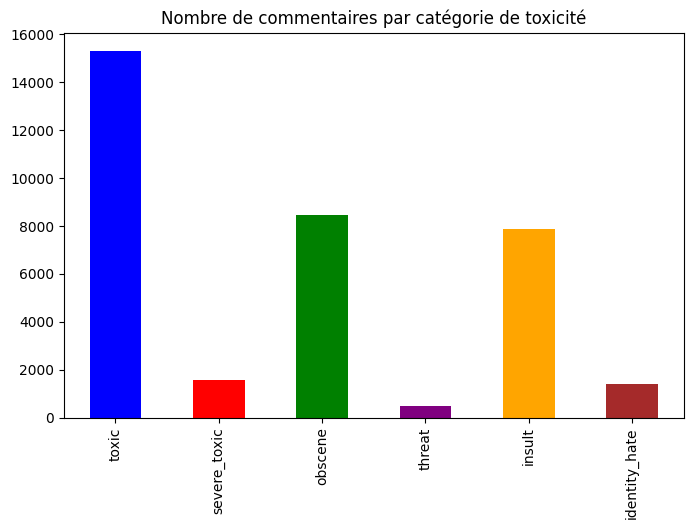

In [43]:
#reparition des classes par catégorie de toxicité

# Compter les occurrences de chaque classe
label_counts = data.iloc[:, 2:].sum()

# Affichage en barres
plt.figure(figsize=(8,5))
label_counts.plot(kind='bar', color=['blue', 'red', 'green', 'purple', 'orange', 'brown'])
plt.title("Nombre de commentaires par catégorie de toxicité")
plt.show()


notre jeu de données est constitué de commentaires jugés non toxiques :


In [44]:
#voir le pourcentage de commentaires jugés non toxiques

clean_comments = (data.iloc[:, 2:].sum(axis=1) == 0).mean()
print(f"Pourcentage de commentaires non toxiques: {clean_comments:.2%}")


Pourcentage de commentaires non toxiques: 89.83%


On affiche des exemples de commentaires pour pouvoir avoir en plus une idée visuel des types d'insultes, menaces, etc...

In [45]:
#voir des exemples de commentaires (1 toxique et 1 non toxique)

# Exemple d'un commentaire toxique
print(data[data["toxic"] == 1]["comment_text"].sample(5).values)

# Exemple d'un commentaire propre
print(data[(data.iloc[:, 2:].sum(axis=1) == 0)]["comment_text"].sample(5).values)


["Iranian Mullah, Like You \n\nYou for all intents and purposes just called me a dipshit by removing my completely reasonable comment at the Neda talk page.  You dipshit.  No one gives you the right to be like the Iranian Mullah just because you dislike someone's views on a matter. 74.233.165.176"
 "I'm going to kill you all. \n\nI'm serious. You are all Retarder losers who deserve to die and I'm going to make sure that every single one of you suffers a horrible death."
 "Hey Gwernol, go suck a dick you fuckin piece of shit, I told you that you cant stop me, whether I'm Eoganan, Pan-ethnic, whoever the fuck, I will bring this piece of shit thing down, AND put faggot users like Wobble in their place. Anyone can edit this shit, so go fuck yaself biatch !"
 'Wow what a load of shit wiki is.... List of Filipino American Populations states and I quote\n\nOutside of California, one of the nation’s largest settlements of Filipino Americans is New York City, where nearly 60,000 Filipino Americ

In [46]:
#vérifier qu'aucune donnée n'est manquante

print(data.isnull().sum())


id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


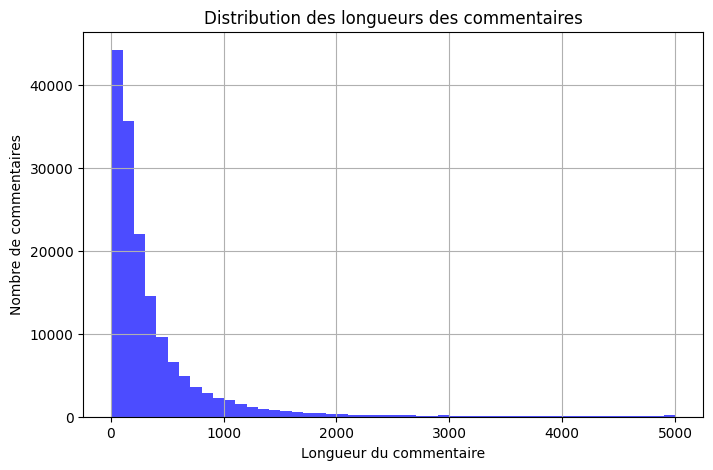

In [47]:
#analyse des longueurs de commentaires

data["comment_length"] = data["comment_text"].apply(len)

plt.figure(figsize=(8,5))
data["comment_length"].hist(bins=50, color='blue', alpha=0.7)
plt.title("Distribution des longueurs des commentaires")
plt.xlabel("Longueur du commentaire")
plt.ylabel("Nombre de commentaires")
plt.show()


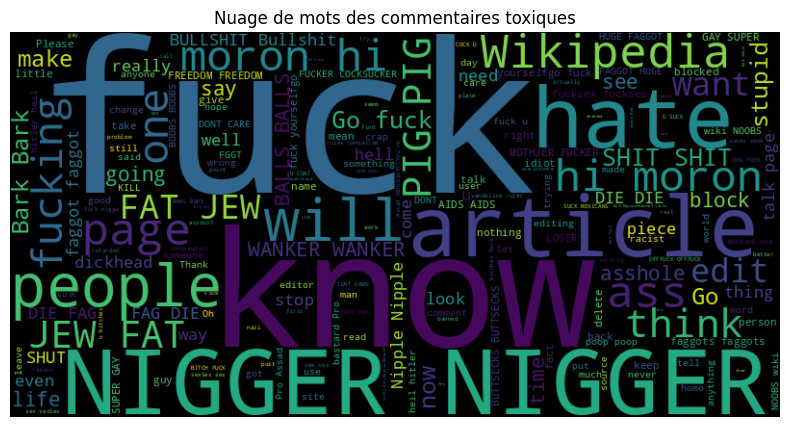

In [49]:
#faire un nuage de mot pour voir les mots toxiques récurrents

from wordcloud import WordCloud

toxic_comments = " ".join(data[data["toxic"] == 1]["comment_text"])
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(toxic_comments)

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots des commentaires toxiques")
plt.show()


# Préparation des données

Nous avons pu analyser les données et donc voir ce que nous avons dans notre jeu de données.

Nous avons maintenant une colonne contenant des commentaires sous forme de texte brut, et pour pouvoir les utiliser efficacement dans nos analyses, nous devons les nettoyer.

---

**Pourquoi nettoyer le texte ?**

Le nettoyage du texte permet de simplifier les données en éliminant des éléments qui ne sont pas pertinents pour l'analyse. Par exemple, des éléments comme les liens URL, les mentions de profils sur les réseaux sociaux (comme @username), les hashtags (#motcle), ou encore les ponctuations, ne nous aident généralement pas à comprendre le sens du texte. L'objectif est de nous concentrer sur les mots porteurs de sens.

---

**Comment procédons-nous pour nettoyer le texte ?**

On met en minuscules, nous commençons par transformer tout le texte en minuscules. Cela garantit que nous traitons "Bonjour" et "bonjour" de la même manière.

On s'occupe aussi de supprimer les liens, les mentions et les hashtags, ils n'ont pas d'utilités pour ce projet et nous cherchons à nous concentrer sur les commentaires toxiques.

On supprime la ponctuation et les chiffres.

---

**Tokenisation :**

Ensuite, nous divisons le texte en mots, un processus appelé "tokenisation". Cela nous permet de traiter chaque mot individuellement, facilitant ainsi les analyses ultérieures.

Suppression des "stopwords" plus précisement certains mots très fréquents, comme "et", "le", "la", "is", "in", etc., sont retirés car ils n'apportent pas de valeur significative à l'analyse.

In [71]:
#nettoyage du texte

import nltk
nltk.download('punkt')
nltk.download('punkt_tab') # Download the punkt_tab data
nltk.download('stopwords')  # Add this line to download stopwords



STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    # Mettre en minuscules
    text = text.lower()
    # Supprimer les liens
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    # Supprimer les mentions et hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Supprimer la ponctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Supprimer les chiffres
    text = re.sub(r'\d+', '', text)
    # Tokenization
    words = word_tokenize(text)
    # Supprimer les stopwords
    words = [word for word in words if word not in STOPWORDS]
    return " ".join(words)

# Appliquer le nettoyage
data["clean_text"] = data["comment_text"].apply(clean_text)

# Vérifier le résultat
print(data[["comment_text", "clean_text"]].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                        comment_text  \
0  Explanation\nWhy the edits made under my usern...   
1  D'aww! He matches this background colour I'm s...   
2  Hey man, I'm really not trying to edit war. It...   
3  "\nMore\nI can't make any real suggestions on ...   
4  You, sir, are my hero. Any chance you remember...   

                                          clean_text  
0  explanation edits made username hardcore metal...  
1  daww matches background colour im seemingly st...  
2  hey man im really trying edit war guy constant...  
3  cant make real suggestions improvement wondere...  
4                sir hero chance remember page thats  


**Stemming :**

Cela consiste à réduire un mot à sa racine, en coupant les suffixes. Par exemple, "running" devient "run". Cette méthode est souvent plus rapide mais peut parfois donner des résultats moins précis.


\
**Lemmatisation :**

La lemmatisation est un processus plus sophistiqué qui transforme un mot en son "lemme" (forme canonique) en prenant en compte son sens et sa position grammaticale. Par exemple, "better" sera transformé en "good", et "running" sera réduit à "run" en tant que verbe.

In [51]:
#stemming

from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download("wordnet")

stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatisation
    return " ".join(words)

# Appliquer la transformation
data["processed_text"] = data["clean_text"].apply(preprocess_text)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


On représenter les mots sous forme de vecteurs numériques, ce qui permet de capturer leurs relations sémantiques. Word2Vec est un modèle d'apprentissage qui génère ces représentations vectorielles.

In [52]:
#word embeddings pour representer le texte

from gensim.models import Word2Vec

tokenized_sentences = [word_tokenize(text) for text in data["processed_text"]]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=2, workers=4)

# Exemple de représentation pour "toxic"
print(word2vec_model.wv["toxic"])

[-0.17219946 -0.07160266  0.1980522   0.199414   -0.48322874 -0.17882961
 -0.1275997   0.5725801  -0.2208895  -0.04465617  0.21600908 -0.2063569
  0.1087765  -0.1401956  -0.45293063 -0.22946192 -0.07348968 -0.19841488
  0.3524614  -0.4275118   0.29640535  0.14104934 -0.28772596 -0.5549982
 -0.28593957  0.18618146  0.05507606 -0.28899458 -0.6841801  -0.12172259
  0.0315515   0.42918706  0.00071008 -0.22471248 -0.05726883  0.13505317
  0.08565382 -0.29095548 -0.01882697 -0.21354973  0.05536507 -0.543119
 -0.06110248  0.0351877   0.32162687  0.04591651  0.17948449 -0.2315122
 -0.02893322  0.13082746  0.10212868 -0.13045843  0.08312169 -0.2989063
 -0.23802485  0.04530782 -0.3889984   0.20262732 -0.25075686 -0.16364224
  0.35809663  0.40845594  0.1537503   0.28184283 -0.3854093   0.24196689
 -0.09540681  0.07339774 -0.2611082   0.01734687 -0.20259346  0.20499305
  0.5170473  -0.14834781  0.20850249  0.2441512  -0.08133449 -0.48441368
  0.24462175  0.1909088   0.30350766 -0.05919795 -0.62918

Comme les commentaires "toxiques" sont beaucoup plus fréquentes que d'autres. Cela peut biaiser les modèles d'apprentissage automatique. Pour corriger cela, nous utilisons les poids de classe.

In [38]:
#gestion des desequilibre des classes

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Get unique classes from the target variable
unique_classes = np.unique(data[labels].values) # Get unique classes from all target columns

# Calculer les poids des classes
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=data[labels].values.ravel())
print(class_weights)

[ 0.51902685 13.63932418]


# Entraînement du modèle baseline

Nous allons utiliser 2 techniques, la première sera du random forest et pour la deuxième nous utiliserons BERT de Google

####Random Forest


In [63]:
# Random Forest

# Random Forest avec Pipeline


# Charger les données (assumons que 'data' est déjà défini)
# Prendre un échantillon aléatoire de 10% des données
sample_df = data.sample(frac=0.5, random_state=42)

# Features et labels
X = sample_df["processed_text"]
y = sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création de la pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),  # Étape 1 : Vectorisation TF-IDF
    ('rf', MultiOutputClassifier(RandomForestClassifier(n_estimators=200, random_state=42)))  # Étape 2 : Modèle Random Forest multi-label
])

# Entraînement de la pipeline
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
print(classification_report(y_test, y_pred, target_names=["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]))

# (Optionnel) Sauvegarde de la pipeline
import joblib
joblib.dump(pipeline, "rf_toxicity_pipeline.pkl")
print("✅ Pipeline sauvegardée !")


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


               precision    recall  f1-score   support

        toxic       0.84      0.63      0.72      1521
 severe_toxic       0.38      0.05      0.09       163
      obscene       0.84      0.75      0.79       829
       threat       0.50      0.04      0.08        49
       insult       0.75      0.58      0.66       793
identity_hate       0.78      0.14      0.24       150

    micro avg       0.81      0.59      0.69      3505
    macro avg       0.68      0.37      0.43      3505
 weighted avg       0.79      0.59      0.66      3505
  samples avg       0.06      0.05      0.05      3505

✅ Pipeline sauvegardée !


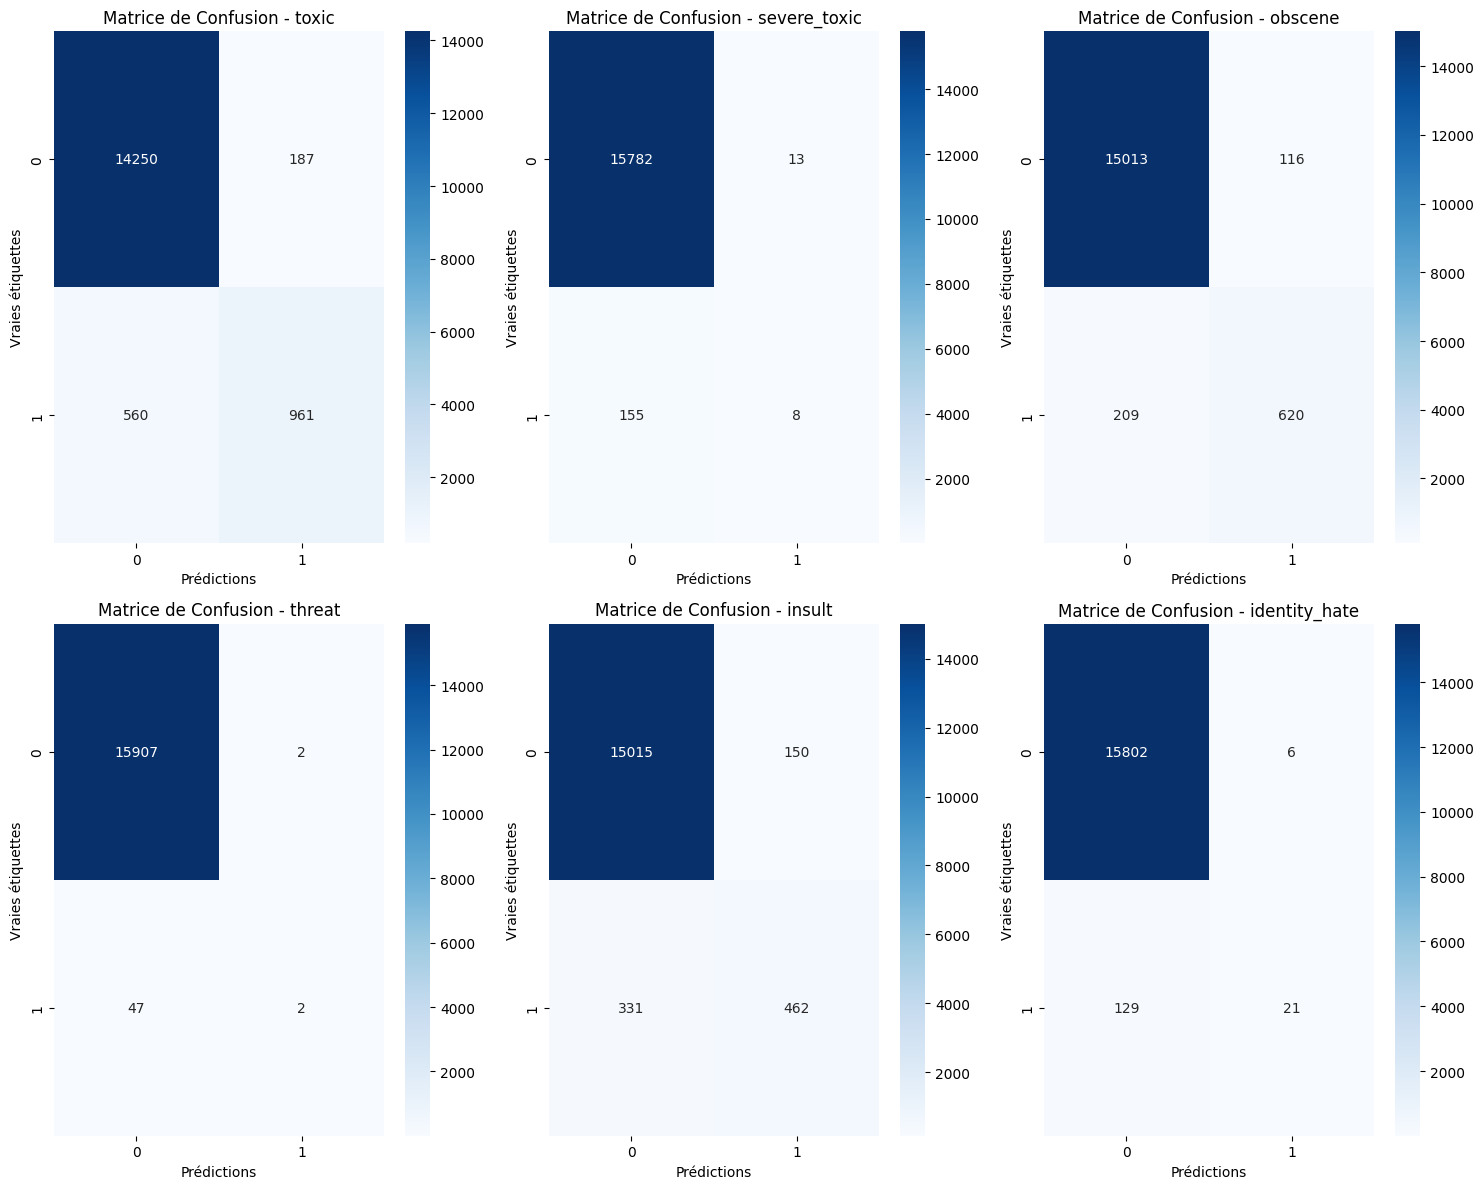

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Prédictions
y_pred = pipeline.predict(X_test)

# Étiquettes de sortie
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# Initialisation de la figure
plt.figure(figsize=(15, 12))

# Itérer sur chaque label pour générer la matrice de confusion
for i, label in enumerate(labels):
    plt.subplot(2, 3, i+1)

    # Calcul de la matrice de confusion pour chaque étiquette
    cm = confusion_matrix(y_test[label], y_pred[:, i])

    # Visualisation avec seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["0", "1"], yticklabels=["0", "1"])

    # Ajouter le titre et les labels
    plt.title(f'Matrice de Confusion - {label}')
    plt.xlabel('Prédictions')
    plt.ylabel('Vraies étiquettes')

plt.tight_layout()
plt.show()


In [74]:
def predict_toxicity(text):
    # Charger la pipeline
    pipeline = joblib.load("rf_toxicity_pipeline.pkl")

    # Prédire directement sur le texte brut
    prediction = pipeline.predict([text])[0]  # [text] car predict attend une liste

    # Convertir en dictionnaire
    labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
    results = {label: int(pred) for label, pred in zip(labels, prediction)}

    return results

# Test interactif
while True:
    user_text = input("Entrez un message (ou 'exit' pour quitter) : ")
    if user_text.lower() == "exit":
        break
    prediction = predict_toxicity(user_text)
    print("\nPrédiction :", prediction)

Entrez un message (ou 'exit' pour quitter) : salope

Prédiction : {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : kys

Prédiction : {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : hate

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : piece of shit

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}


KeyboardInterrupt: Interrupted by user

####BERT

In [60]:
!pip install datasets

In [61]:
# BERT de Google

import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split

# Prendre 10% des données
sample_df = data.sample(frac=0.1, random_state=42)

# Charger le tokenizer
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

# Fonction de tokenization
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Séparation en train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    sample_df["comment_text"].tolist(), sample_df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values, test_size=0.2
)

# Conversion en Dataset Hugging Face
train_dataset = Dataset.from_dict({"text": train_texts, "labels": train_labels.tolist()})
test_dataset = Dataset.from_dict({"text": test_texts, "labels": test_labels.tolist()})

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Charger le modèle BERT
model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=6)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Map:   0%|          | 0/12765 [00:00<?, ? examples/s]

Map:   0%|          | 0/3192 [00:00<?, ? examples/s]

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

In [62]:
# Entrainement sur 10% des données

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=1,  # On fait 1 epoch pour tester rapidement
    weight_decay=0.01,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: florian-vitoux (florian-vitoux-junia) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


ValueError: Expected input batch_size (8) to match target batch_size (48).

In [ ]:
# Evaluation

predictions = trainer.predict(test_dataset)
preds = torch.sigmoid(torch.tensor(predictions.predictions))  # Activation sigmoïde
preds = (preds.numpy() > 0.5).astype(int)  # Seuil 0.5 pour classifier

print(classification_report(test_labels, preds))


              precision    recall  f1-score   support

           0       0.09      1.00      0.16       287
           1       0.01      1.00      0.02        27
           2       0.00      0.00      0.00       171
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00       170
           5       0.00      0.00      0.00        30

   micro avg       0.05      0.46      0.09       690
   macro avg       0.02      0.33      0.03       690
weighted avg       0.04      0.46      0.07       690
 samples avg       0.05      0.05      0.05       690



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


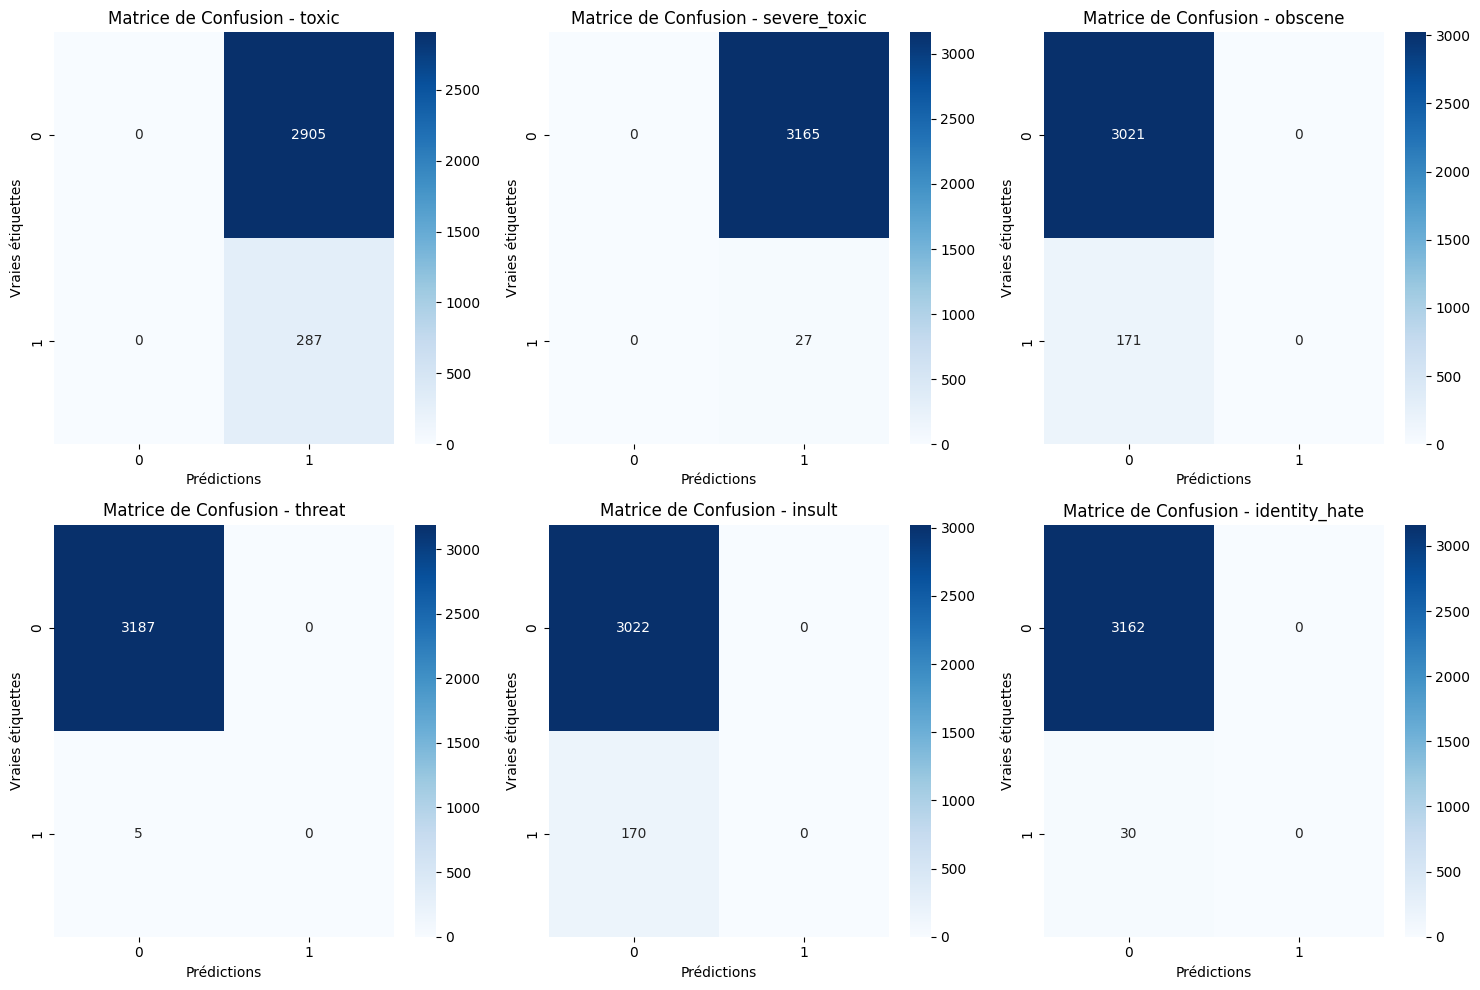

Rapport de classification pour toxic:
  Précision: 0.09
  Rappel: 1.00
  F1-score: 0.16
  Support: 287.0
------------------------------
Rapport de classification pour severe_toxic:
  Précision: 0.01
  Rappel: 1.00
  F1-score: 0.02
  Support: 27.0
------------------------------
Rapport de classification pour obscene:
  Précision: 0.00
  Rappel: 0.00
  F1-score: 0.00
  Support: 171.0
------------------------------
Rapport de classification pour threat:
  Précision: 0.00
  Rappel: 0.00
  F1-score: 0.00
  Support: 5.0
------------------------------
Rapport de classification pour insult:
  Précision: 0.00
  Rappel: 0.00
  F1-score: 0.00
  Support: 170.0
------------------------------
Rapport de classification pour identity_hate:
  Précision: 0.00
  Rappel: 0.00
  F1-score: 0.00
  Support: 30.0
------------------------------


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report
import torch
import numpy as np

# Prédictions sur les données de test avec BERT
predictions = trainer.predict(test_dataset)
preds = torch.sigmoid(torch.tensor(predictions.predictions))  # Activation sigmoïde
preds = (preds.numpy() > 0.5).astype(int)

# Calculer la matrice de confusion pour chaque étiquette
cms = multilabel_confusion_matrix(test_labels, preds) # Use multilabel_confusion_matrix instead

# Afficher les matrices de confusion
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for i, (label, cm) in enumerate(zip(labels, cms)):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Matrice de Confusion - {label}')
    axes[i].set_xlabel('Prédictions')
    axes[i].set_ylabel('Vraies étiquettes')
plt.tight_layout()
plt.show()

# Calculer et afficher le rapport de classification pour chaque étiquette
report = classification_report(test_labels, preds, target_names=labels, output_dict=True) # Add target_names for better readability
for label in labels:
    print(f"Rapport de classification pour {label}:")
    print(f"  Précision: {report[label]['precision']:.2f}")
    print(f"  Rappel: {report[label]['recall']:.2f}")
    print(f"  F1-score: {report[label]['f1-score']:.2f}")
    print(f"  Support: {report[label]['support']}")
    print("-" * 30)

# Itération de la modélisation

Entrez un message (ou 'exit' pour quitter) : kill yourself

Prédiction : {'toxic': 1, 'severe_toxic': 1, 'obscene': 0, 'threat': 1, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : go back to the kitchen women

Prédiction : {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : bitch

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : suck my balls

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 1, 'threat': 0, 'insult': 1, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : go die in heaven

Prédiction : {'toxic': 1, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate': 0}
Entrez un message (ou 'exit' pour quitter) : i m gonna find you

Prédiction : {'toxic': 0, 'severe_toxic': 0, 'obscene': 0, 'threat': 0, 'insult': 0, 'identity_hate'

KeyboardInterrupt: Interrupted by user